In [378]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
import os
import shutil
import gpt

In [379]:
IMAGE_PATH = "./diary.png"

#Open Image
image = image = Image.open(IMAGE_PATH)

#Convert image to numpy array
#Creates 3d array; Array of rows of pixels (and their rgb values)
img_arr = np.array(image, dtype=np.int32)
original_img_arr = np.array(image, dtype=np.uint8)

Make each row the avg color in black and white

In [380]:
for row in img_arr:
    R = 0
    G = 0
    B = 0
    for pixel in row:
        R = R + pixel[0]
        G = G + pixel[1]
        B = B + pixel[2]
    
    #Set every pixel to its average r g and b value
    avg_R = R/len(row)
    avg_G = G/len(row)
    avg_B = B/len(row)
    
    avg = (avg_R+avg_B+avg_G)/3
    
    for pixel in row:
        pixel[0] = avg
        pixel[1] = avg
        pixel[2] = avg

Convert back to image

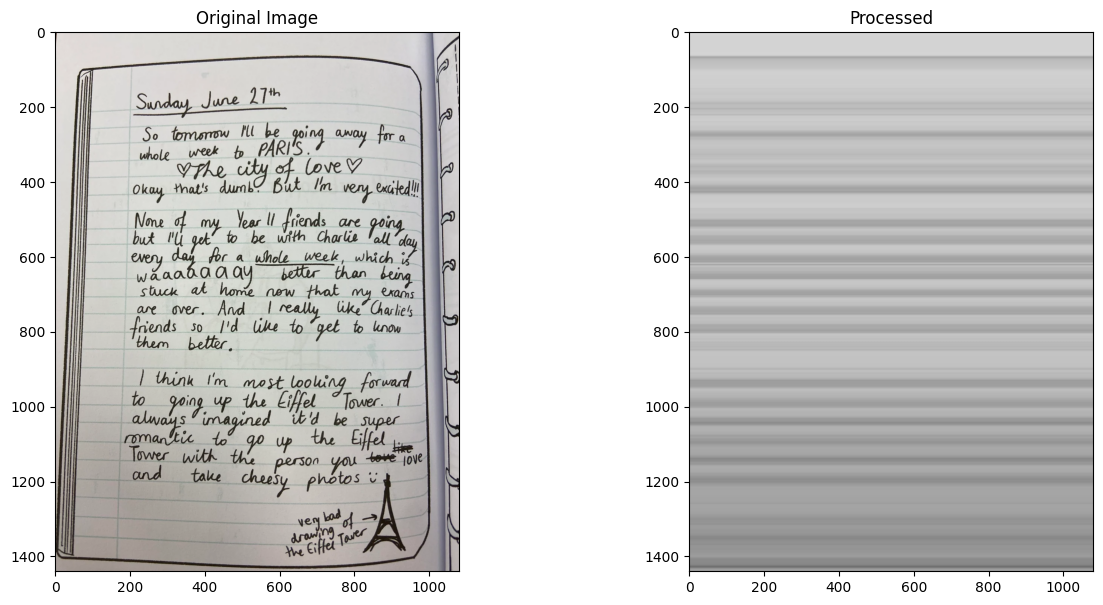

In [381]:
# Convert the processed array back to uint8 for pillow compatibility
formatted_img_arr = np.clip(img_arr, 0, 255).astype(np.uint8)

result_img = Image.fromarray(formatted_img_arr)

plt.figure(figsize=(15, 7))  # Adjust figure size as needed

#Show Images
plt.subplot(1, 2, 1)  # (rows, columns, index)
plt.imshow(np.array(image))
#plt.axis('off')
plt.title("Original Image")

plt.subplot(1, 2, 2)  # (rows, columns, index)
plt.imshow(np.array(result_img))
#plt.axis('off')
plt.title("Processed")

plt.show()

Notice How you can see the line breaks. This might be useful when breaking up pages into chunks to feed into the AI

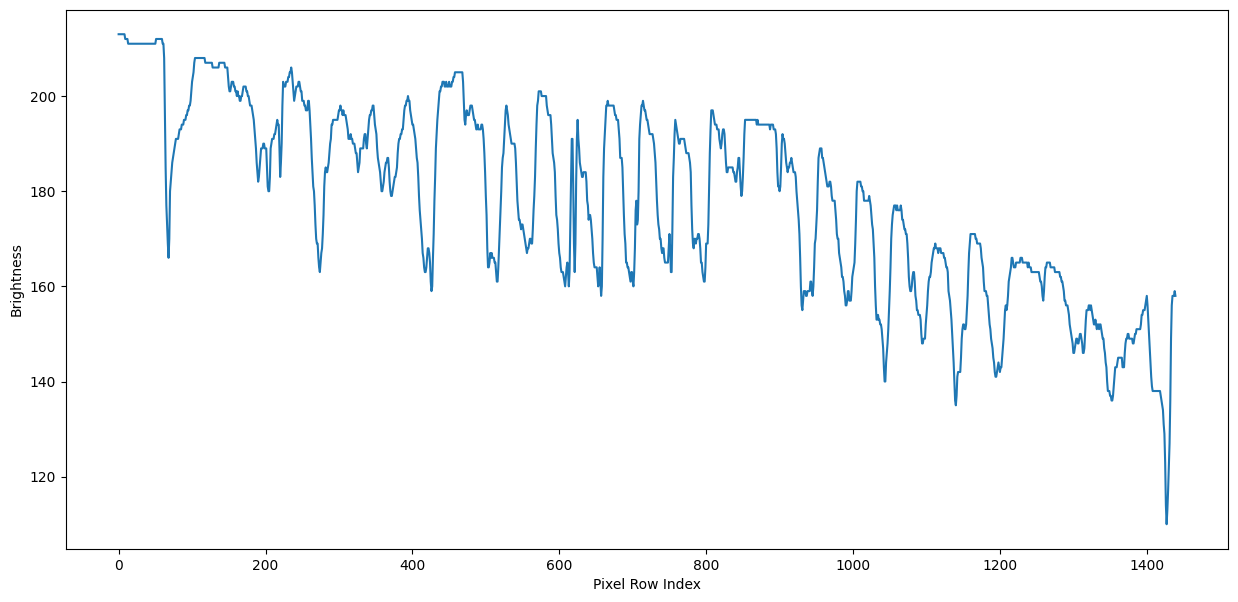

In [382]:
brightness = []

for row in img_arr:
    brightness.append(row[0][0])

plt.figure(figsize=(15, 7))
plt.plot(brightness)
plt.xlabel("Pixel Row Index")
plt.ylabel("Brightness")
plt.show()

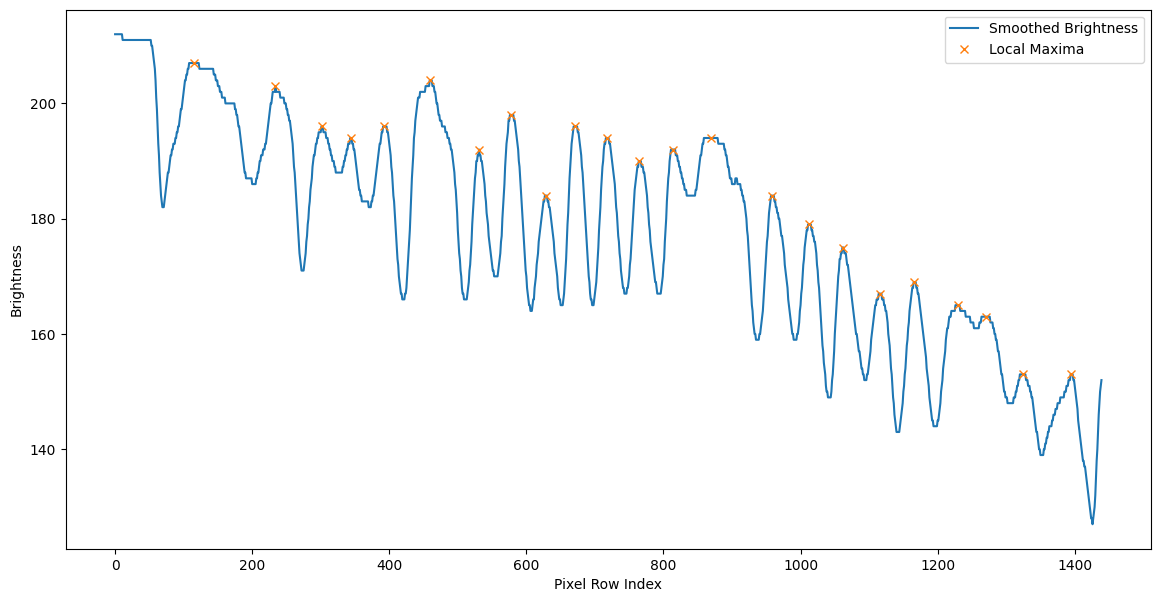

In [383]:
brightness_np = np.array(brightness)

smoothed_data = gaussian_filter1d(brightness_np, sigma=5)

# Find peaks (local maxima)
peaks, _ = find_peaks(smoothed_data, distance=40)  # Adjust distance based on your data

# Plot the smoothed data and the detected peaks
plt.figure(figsize=(14, 7))
plt.plot(smoothed_data, label="Smoothed Brightness")
plt.plot(peaks, smoothed_data[peaks], "x", label="Local Maxima")
plt.xlabel("Pixel Row Index")
plt.ylabel("Brightness")
plt.legend()
plt.show()

In [384]:
lined_img_arr = original_img_arr.copy()

for i, row in enumerate(img_arr):
    if i in peaks:
        for pixel in row:
            pixel[0] = 255
            pixel[1] = 255
            pixel[2] = 0

for i, row in enumerate(lined_img_arr):
    if i in peaks:
        for pixel in row:
            pixel[0] = 255
            pixel[1] = 255
            pixel[2] = 0
            

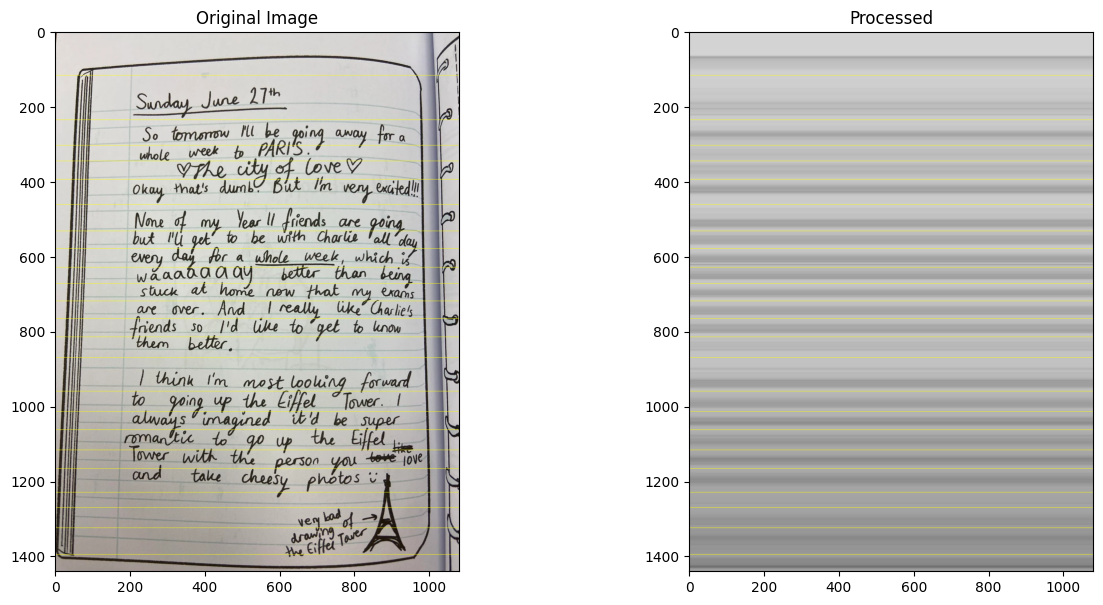

In [385]:
# Convert the processed array back to uint8 for pillow compatibility
formatted_img_arr = np.clip(img_arr, 0, 255).astype(np.uint8)

result_img = Image.fromarray(formatted_img_arr)
tweaked_img = Image.fromarray(lined_img_arr)

plt.figure(figsize=(15, 7))  # Adjust figure size as needed

#Show Images
plt.subplot(1, 2, 1)  # (rows, columns, index)
plt.imshow(np.array(tweaked_img))
#plt.axis('off')
plt.title("Original Image")

plt.subplot(1, 2, 2)  # (rows, columns, index)
plt.imshow(np.array(result_img))
#plt.axis('off')
plt.title("Processed")

plt.show()

In [386]:
split_images = []
mini_image = []

for i, row in enumerate(original_img_arr):
    mini_image.append(row)
    
    # If the image should be split on this row
    if i in peaks:
        split_images.append(np.array(mini_image))  # Convert mini_image to a numpy array before appending
        mini_image = []  # Reset the mini image

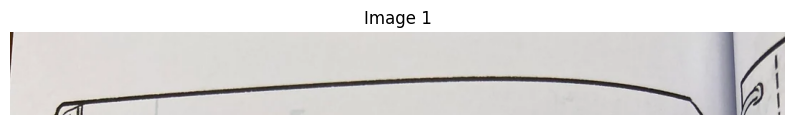

[No Image]


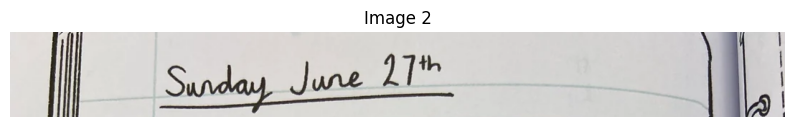

S u n d a y [Sunday] 95%  
J u n e [June] 95%  
2 7 t h [27th] 90%  


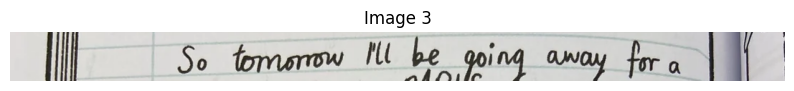

S o [So] 95%  
t o m o r r o w [tomorrow] 98%  
I ' l l [I'll] 97%  
b e [be] 99%  
g o i n g [going] 98%  
a w a y [away] 95%  
f o r [for] 99%  
a [a] 99%  
A l o n g [along] 84%  


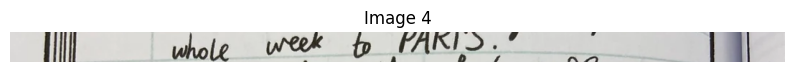

w h o l e [whole] 95%  
w e e k [week] 96%  
t o [to] 98%  
P A R I S [PARIS] 90%  
! [!] 99%


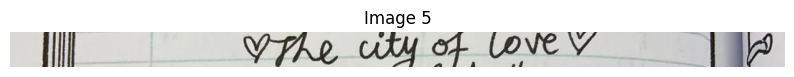

T h e [The] 95%  
c i t y [city] 90%  
o f [of] 97%  
l o v e [love] 95%  
♥ [♥] 100%  
♥ [♥] 100%  


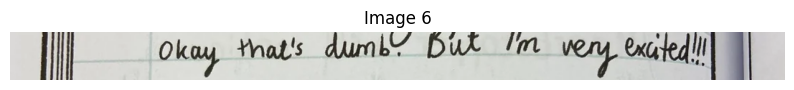

O k a y [Okay] 95%  
t h a t ' s [that's] 92%  
d u m b [dumb] 90%  
B u t [But] 95%  
I ' m [I'm] 95%  
v e r y [very] 94%  
e x c i t e d [excited] 93%  
! [!] 96%  
! [!] 96%  
! [!] 96%  


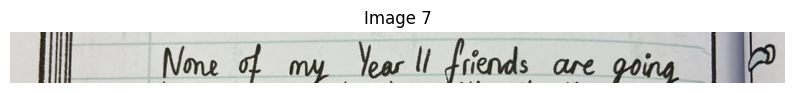

N o n e [None] 98%  
o f [of] 95%  
m y [my] 97%  
Y e a r [Year] 98%  
1 1 [11] 100%  
f r i e n d s [friends] 99%  
a r e [are] 97%  
g o i n g [going] 98%  


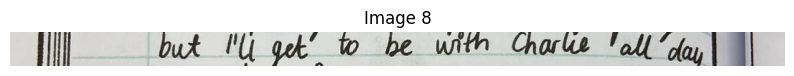

b u t [but] 96%  
_ ' l _ [I'll] 85%  
g e t [get] 97%  
t o [to] 98%  
b e [be] 96%  
w i t h [with] 95%  
C h a r l i e [Charlie] 94%  
_ ' a l l [all] 90%  
d a y [day] 98%  


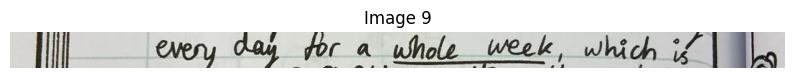

e v e r y [every] 95%  
d a y [day] 99%  
f o r [for] 95%  
a [a] 100%  
w h o l e [whole] 97%  
w e e k [week] 98%  
, [,] 96%  
w h i c h [which] 95%  
i s [is] 96%  
! [!] 97%  


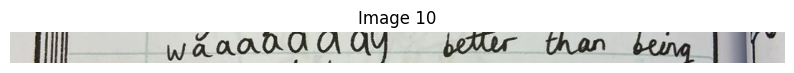

W a _ á a a a d _ a y [way] 80%  
b e t t e r [better] 95%  
t h a n [than] 97%  
b e i n g [being] 95%  


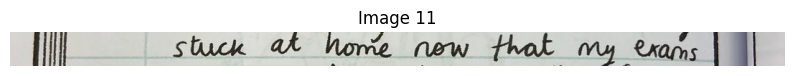

s t u c k [stuck] 95%  
a t [at] 98%  
h o _ e [home] 85%  
n o w [now] 97%  
t h a t [that] 98%  
m y [my] 99%  
e x _ _ [exams] 80%  


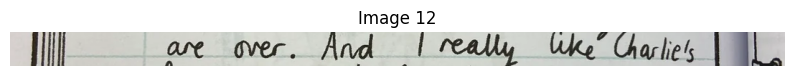

a r e [are] 95%  
o v e r [over] 95%  
A n d [And] 97%  
I [I] 99%  
r e _ l l _ y [really] 83%  
l i k e [like] 95%  
C h a r l i _ ' s [Charlie's] 92%  


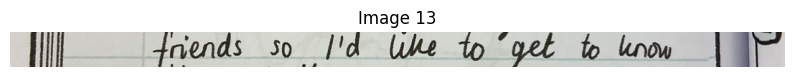

F r i e n d s [friends] 95%  
s o [so] 97%  
I ' d [I'd] 98%  
l i k e [like] 96%  
t o [to] 99%  
g e t [get] 97%  
t o [to] 99%  
k n o w [know] 96%  


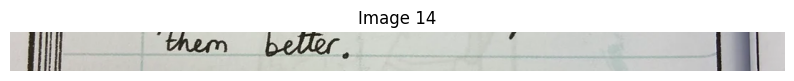

t h e n [then] 95%  
b e t t e r [better] 90%  
. [.] 98%  


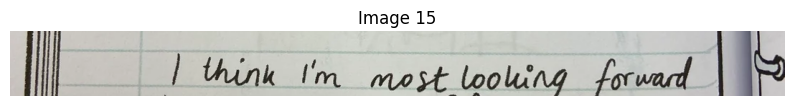

I [I] 99%  
t h i n k [think] 95%  
i ' m [I'm] 98%  
m o s t [most] 95%  
l o o k i n g [looking] 97%  
f o r w a r d [forward] 96%  


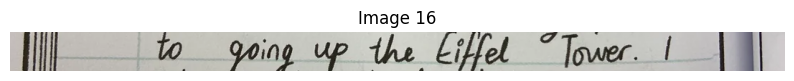

t o [to] 98%  
g o i n g [going] 95%  
u p [up] 99%  
t h e [the] 99%  
E i f f e l [Eiffel] 98%  
T o w e r . [Tower.] 97%  
! [!] 96%  


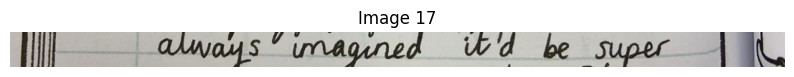

a l w a y s [always] 95%  
' ['] 96%  
i m a g i n e d [imagined] 90%  
i t ’ d [it’d] 92%  
b e [be] 98%  
s u p e r [super] 94%  


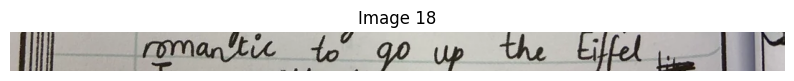

r o m a n t i c [romantic] 95%  
t o [to] 97%  
g o [go] 95%  
u p [up] 97%  
t h e [the] 98%  
E i f f e l [Eiffel] 96%  
_ [_] 90%  


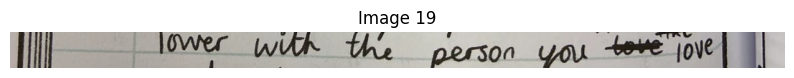

L o v e r [Lover] 95%  
w i t h [with] 98%  
t h e [the] 99%  
p e r s o n [person] 96%  
y o u [you] 99%  
l o v e [love] 95%  


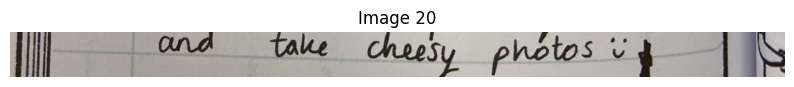

a d d [add] 95%  
t a k e [take] 97%  
c h e e s y [cheesy] 92%  
p h ó t o s [phótos] 90%  
: ) [:)] 99%  


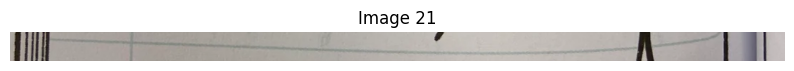

[No Image]


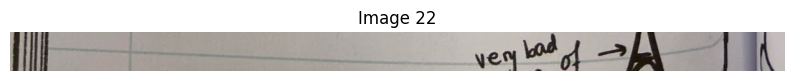

v e r y [very] 95%  
b a d [bad] 97%  
o f [of] 97%  
- [-] 96%  


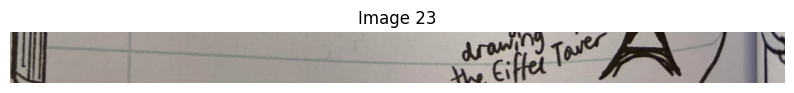

d r a w i n g [drawing] 95%  
t h e [the] 98%  
E i f f e l [Eiffel] 97%  
T o w e r [Tower] 95%  


In [387]:
# Directory to save the split images
output_dir = "split_images"

# Clear the directory if it exists
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)  # Remove the directory and all its contents
os.makedirs(output_dir, exist_ok=True)  # Recreate the empty directory

# Convert split images to PIL images and save them
for i, pic in enumerate(split_images):
    # Convert to PIL Image
    converted_img = Image.fromarray(pic)
    
    # Save the image
    image_path = os.path.join(output_dir, f"image_{i+1}.png")
    converted_img.save(image_path)
    
    # Display each image
    plt.figure(figsize=(10, 10))  # Adjust size as needed
    plt.imshow(pic)
    plt.axis('off')
    plt.title(f"Image {i+1}")
    plt.show()
    
    gpt.run_chatgpt(image_path)

plt.show()